<img style="float: right; width: 150px;" src="data/firrm.jpg">

## <span style="color:#4375c7">Food Prices in Germany: A descriptive time-series analysis</span>
***
*This is the main JupyterHub File including all the relevant code of the project. It is segmented by the different statistical test executed. This file uses external content of different databases.*
***

## Structure
This file is strucured as follows:

### Content:
1. **[Library Import](#101)**
2. **[Data](#fit)**
3. **[Descriptive Summary Statistics](#summary)**
4. **[Augmented Dickey-Fuller Test](#ADF)**
5. **[VAR-Model](#VAR)**
6. **[Granger Causality Test](#GRANGER)**
7. **[Impulse Response Function](#IRF)**



***

## 1. Library Import <a id='101'></a>

First, relevant libraries are installed and imported. 


In [3]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install statsmodels


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd                                                    
import numpy as np      
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR                                   # Import VAR Class                  
from statsmodels.tsa.base.datetools import dates_from_str 
from statsmodels.tsa.stattools import adfuller                        # Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import grangercausalitytests           # Import Granger-Causality Test
from tabulate import tabulate
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression

## 2. Import and Adjustment of Data  <a id='fit'></a>

After importing libraries the next step is to import historical Food-Prices and possible determinants. The imported time-Series are cleaned of errors and missing values and are merged into one single dataframe. Finally, a dataframe of daily percent change is created.

In [7]:
df = pd.read_csv("F:\Git\Food-price-forecast\ModelsAndDatasets\Datasets\price_temp_grain_starch.csv")
df = df.drop(columns=["Unnamed: 0"])   #Delete redundant column
df.index = pd.to_datetime(df['Date'], format = '%Y-%m') #Date as Index
df = df.drop(df.columns[[0]],axis = 1) # delete redundant column
df = df[df.index <= "2021-12-01"]  #Limit timeframe

#Create Seperate Dataframe for each variable 

food_price = pd.DataFrame(df["Food_Price"])   
food_price = food_price.rename(columns={"Food_Price": "food_price"})
food_price.dropna()              #Drop missing values

air_temp = pd.DataFrame(df["Air_Temperature"])   
air_temp = air_temp.rename(columns={"Air_Temperature": "air_temperature"}) 
air_temp.dropna()               #Drop missing values

grain_price = pd.DataFrame(df["grain_starch_output_price"])
grain_price = grain_price.rename(columns={"grain_starch_output_price": "grain_price"})   
grain_price["grain_price"] = grain_price["grain_price"].astype(float)                              #Grain Price in floats
grain_price.dropna()            #Drop missing values


,grain_price
Date,
1996-01-01,87.3
1996-02-01,87.4
1996-03-01,87.7
1996-04-01,87.8
1996-05-01,88.8
...,...
2021-08-01,107.2
2021-09-01,108.2
2021-10-01,112.8


In [8]:
abs_values = food_price.join(air_temp)                             # Merge both Time-Series into one dataframe
abs_values = abs_values.join(grain_price)


In [9]:
pct_values = abs_values.pct_change()                                # Deduct daily percent change dataframe from absolute dataframe
pct_values = pct_values.dropna()                                    # Filter for missing values and errors

pct_values

,food_price,air_temperature,grain_price
Date,,,
1996-02-01,0.008011,-0.226950,0.001145
1996-03-01,0.007947,-1.458716,0.003432
1996-04-01,0.003942,7.400000,0.001140
1996-05-01,-0.002618,0.327381,0.011390
1996-06-01,-0.001312,0.403587,0.006757
...,...,...,...
2021-08-01,0.000000,-0.107240,0.006573
2021-09-01,0.000000,-0.075610,0.009328
2021-10-01,0.000000,-0.364776,0.042514


## 3. Descriptive Summary Statistics  <a id='summary'></a>

Both dataframes, absolute and percentual, are analyzed. The amount of datapoints, mean, standard deviation, minimum value, 50% percentile and maximum value are then depicted in a final table.

In [10]:
summary_abs = abs_values.describe().T                                                    # Create and transpose descriptive summary statistics for absolute dataframe
summary_abs = summary_abs.drop(['25%'],axis=1)                                           # Remove 25% percentile from dataframe
summary_abs = summary_abs.drop(['75%'],axis=1)                                           # Remove 75% percentile from dataframe

In [11]:
summary_pct = pct_values.describe().T                                                    # Create and transpose descriptive summary statistics for relative dataframe
summary_pct = summary_pct.drop(['25%'],axis=1)                                           # Remove 25% percentile from dataframe 
summary_pct = summary_pct.drop(['75%'],axis=1)                                           # Remove 75% percentile from dataframe

In [12]:
complete_summary = pd.concat([summary_abs,summary_pct])                                  # Merge both summaries 
complete_summary.round(2)                                                                #Round values

,count,mean,std,min,50%,max
food_price,312.0,90.02,12.06,74.20,88.40,116.00
air_temperature,312.0,9.36,6.50,-3.66,8.94,21.99
grain_price,312.0,94.56,10.82,78.50,95.00,117.10
food_price,311.0,0.00,0.01,-0.03,0.00,0.03
air_temperature,311.0,0.26,6.94,-27.89,-0.02,114.71
grain_price,311.0,0.00,0.01,-0.03,0.00,0.06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


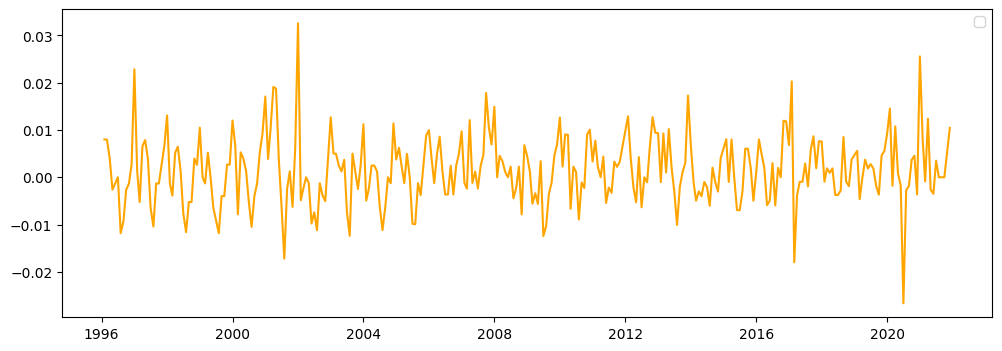

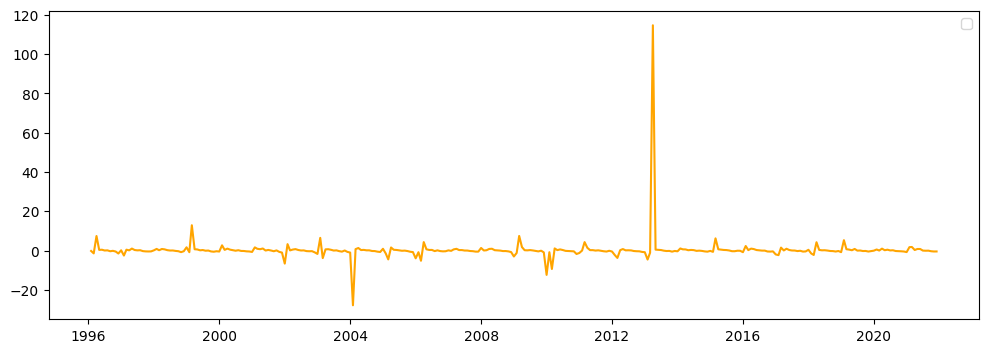

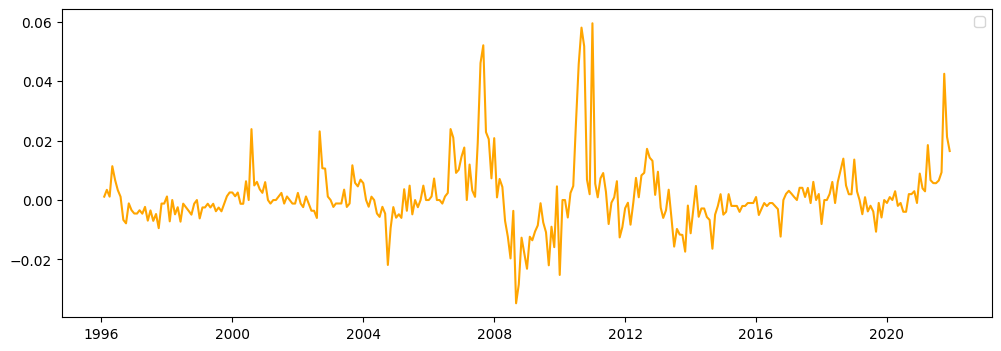

In [13]:
plt.figure(figsize=(12,4))
plt.plot(pct_values['food_price'],color = "orange")
plt.legend()

plt.figure(figsize=(12,4))
plt.plot(pct_values['air_temperature'],color = "orange")
plt.legend()

plt.figure(figsize=(12,4))
plt.plot(pct_values['grain_price'],color = "orange")
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


            food_price  air_temperature  grain_price
Date                                                
2013-04-01    0.001019       114.714286    -0.003463
            food_price  air_temperature  grain_price
Date                                                
2013-05-01        99.2            11.78        115.5
            food_price  air_temperature  grain_price
Date                                                
2013-04-01        98.2              8.1        115.1
            food_price  air_temperature  grain_price
Date                                                
2013-03-01        98.1             0.07        115.5
            food_price  air_temperature  grain_price
Date                                                
2013-02-01        97.2            -0.72        116.2


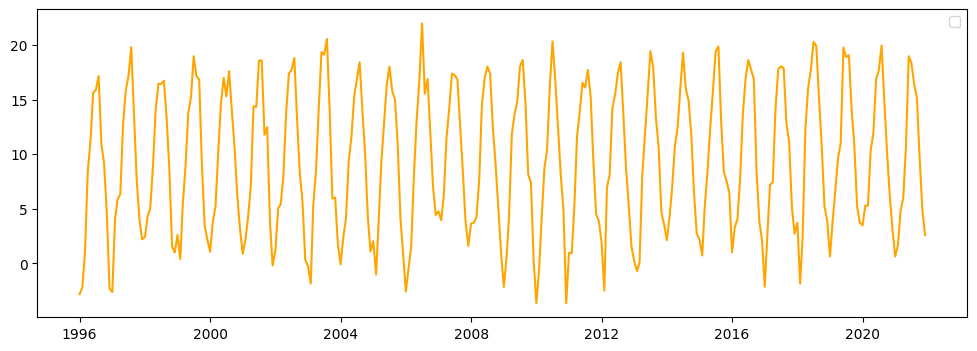

In [14]:
#Check if the outlier of the second graph (temperature) is valid

print(pct_values[pct_values.air_temperature >= 20])
print(abs_values[abs_values.index == "2013-05-01"])
print(abs_values[abs_values.index == "2013-04-01"])
print(abs_values[abs_values.index == "2013-03-01"])
print(abs_values[abs_values.index == "2013-02-01"])


plt.figure(figsize=(12,4))
plt.plot(abs_values['air_temperature'],color = "orange")
plt.legend()

#seems to be valid, no inplausible absolute temperature in given timeframe

## 4. Augmented Dickey-Fuller Test  <a id='ADF'></a>

In order to test for stationarity of the time-series the augmented dickey fuller test is applied. A loop is applied to test the ADF test with 1,3 and 5 lags, printing out respective p-values and adf-statistics. H0: A unit root is present in the time-series sample -> Non-stationarity.

In this case the H0 can be rejected indicating stationarity for the given time-series of percentage change values.

In [22]:
#This section assigns variables to tau statistics and p-values of ADF-Test with 1,3 and 5 lags for both time series

for i in [1,3,5]:
    globals()['food_price_p_AR%s' % i] = str(adfuller(pct_values["food_price"], maxlag = i, regression = "ctt", autolag = None, regresults = True)[1])
    globals()['food_price_Tau_AR%s' % i] = str(adfuller(pct_values["food_price"], maxlag = i, regression = "ctt", autolag = None, regresults = True)[0].round(4))
 
for i in [1,3,5]:
    globals()['air_temp_p_AR%s' % i] = str(adfuller(pct_values["air_temperature"], maxlag = i, regression = "ctt", autolag = None, regresults = True)[1])
    globals()['air_temp_Tau_AR%s' % i] = str(adfuller(pct_values["air_temperature"], maxlag = i, regression = "ctt", autolag = None, regresults = True)[0].round(4))

for i in [1,3,5]:
    globals()['grain_price_p_AR%s' % i] = str(adfuller(pct_values["grain_price"], maxlag = i, regression = "ctt", autolag = None, regresults = True)[1])
    globals()['grain_price_Tau_AR%s' % i] = str(adfuller(pct_values["grain_price"], maxlag = i, regression = "ctt", autolag = None, regresults = True)[0].round(4))


In [23]:
#This section creates a complete output table for the ADF-Test


col_names = ["Statistics","%Δfood_price", "%Δair_temp", "%Δgrain_price"] 

for i in [1,3,5]:
    globals()['table_AR%s' % i] = PrettyTable()
    globals()['table_AR%s' % i].title = f"AR({i})"
    globals()['table_AR%s' % i].field_names = col_names

table_AR1.add_row(['Tau Statistic',food_price_Tau_AR1,air_temp_Tau_AR1,grain_price_Tau_AR1])
table_AR1.add_row(['p value',food_price_p_AR1,air_temp_p_AR1,grain_price_p_AR1])

table_AR3.add_row(['Tau Statistic',food_price_Tau_AR3,air_temp_Tau_AR3, grain_price_Tau_AR3])
table_AR3.add_row(['p value',food_price_p_AR3,air_temp_p_AR3, grain_price_p_AR3])

table_AR5.add_row(['Tau Statistic',food_price_Tau_AR5,air_temp_Tau_AR5, grain_price_Tau_AR5])
table_AR5.add_row(['p value',food_price_p_AR5,air_temp_p_AR5,grain_price_p_AR5])
    
ADF_complete = print(table_AR1,table_AR3,table_AR5)

+-----------------------------------------------------------------------------------------+
|                                          AR(1)                                          |
+---------------+------------------------+-----------------------+------------------------+
|   Statistics  |      %Δfood_price      |       %Δair_temp      |     %Δgrain_price      |
+---------------+------------------------+-----------------------+------------------------+
| Tau Statistic |        -10.5593        |        -12.6951       |        -6.2656         |
|    p value    | 2.2746680273120863e-16 | 9.678810356431604e-21 | 3.5217903559650125e-06 |
+---------------+------------------------+-----------------------+------------------------+ +--------------------------------------------------------------------------------------+
|                                        AR(3)                                         |
+---------------+-----------------------+------------------------+--------------------

## 5. VAR-Model


Results of different Vector-Autoregressive-Models (VAR) with 1,3,5,6,12,36 lags. The p-value indicates whether there is statistical evicdence for the influence of feature observations of previous periods on today's food-price.

In [20]:
var_model = VAR(pct_values)
VAR1 = var_model.fit(maxlags = 1)                  # Estimate VAR-Models with 1,3,5 and 6 lags
VAR3 = var_model.fit(maxlags = 3)
VAR5 = var_model.fit(maxlags = 5)
VAR6 = var_model.fit(maxlags = 6)
VAR12 = var_model.fit(maxlags = 12)
VAR36 = var_model.fit(maxlags =36)

print(VAR1.summary())
print(VAR3.summary())
print(VAR5.summary())
print(VAR6.summary())
print(VAR12.summary())

full = var_model.fit(maxlags=35, ic='aic')         # Estimate unrestricted Model by optimizing AIC
full.summary()

f:\Git\Food-price-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Sep, 2023
Time:                     19:27:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.4561
Nobs:                     310.000    HQIC:                  -15.5429
Log likelihood:           1110.50    FPE:                1.67765e-07
AIC:                     -15.6007    Det(Omega_mle):     1.61435e-07
--------------------------------------------------------------------
Results for equation food_price
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.000908         0.000387            2.347           0.019
L1.food_price              0.305532         0.054266            5.630           0.000
L1.air_temperature         0.000062

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Sep, 2023
Time:                     19:27:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.4561
Nobs:                     310.000    HQIC:                  -15.5429
Log likelihood:           1110.50    FPE:                1.67765e-07
AIC:                     -15.6007    Det(Omega_mle):     1.61435e-07
--------------------------------------------------------------------
Results for equation food_price
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.000908         0.000387            2.347           0.019
L1.food_price              0.305532         0.054266            5.630           0.000
L1.air_temperature         0.000062

## 6. Granger Causality Test  <a id='GRANGER'></a>

In order to check for the lead-lag-relation between food-price and air-temperature and grain-price a Granger-causality test is conducted.

H0: X does not Granger-cause Y.

In [28]:
BtoF_test = grangercausalitytests(pct_values[['food_price', 'air_temperature']], maxlag=[1,3,5,12])  
#Test Granger causality of 'air_temperature' on 'food_price' for lags of 1,3 and 5


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2288  , p=0.2685  , df_denom=307, df_num=1
ssr based chi2 test:   chi2=1.2408  , p=0.2653  , df=1
likelihood ratio test: chi2=1.2384  , p=0.2658  , df=1
parameter F test:         F=1.2288  , p=0.2685  , df_denom=307, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1880  , p=0.3145  , df_denom=301, df_num=3
ssr based chi2 test:   chi2=3.6468  , p=0.3022  , df=3
likelihood ratio test: chi2=3.6254  , p=0.3049  , df=3
parameter F test:         F=1.1880  , p=0.3145  , df_denom=301, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5737  , p=0.1673  , df_denom=295, df_num=5
ssr based chi2 test:   chi2=8.1617  , p=0.1475  , df=5
likelihood ratio test: chi2=8.0547  , p=0.1532  , df=5
parameter F test:         F=1.5737  , p=0.1673  , df_denom=295, df_num=5

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.2551  , p=0.2454 

In [29]:
FtoB_test = grangercausalitytests(pct_values[['food_price', 'grain_price']], maxlag=[1,3,5,12]) 
#Test Granger causality of 'grain-price' on 'food-price' for lags of 1,3 and 5


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0998  , p=0.0793  , df_denom=307, df_num=1
ssr based chi2 test:   chi2=3.1301  , p=0.0769  , df=1
likelihood ratio test: chi2=3.1144  , p=0.0776  , df=1
parameter F test:         F=3.0998  , p=0.0793  , df_denom=307, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3550  , p=0.2567  , df_denom=301, df_num=3
ssr based chi2 test:   chi2=4.1595  , p=0.2447  , df=3
likelihood ratio test: chi2=4.1317  , p=0.2476  , df=3
parameter F test:         F=1.3550  , p=0.2567  , df_denom=301, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3406  , p=0.0417  , df_denom=295, df_num=5
ssr based chi2 test:   chi2=12.1395 , p=0.0329  , df=5
likelihood ratio test: chi2=11.9049 , p=0.0361  , df=5
parameter F test:         F=2.3406  , p=0.0417  , df_denom=295, df_num=5

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.6855  , p=0.0696 

In [30]:
VAR_1_BtoF = BtoF_test[1][0]['ssr_chi2test'][0:2]             #Extract chi2 test statistic and p-value for each lag from Test-Summary 
VAR_3_BtoF =BtoF_test[3][0]['ssr_chi2test'][0:2]  
VAR_5_BtoF =BtoF_test[5][0]['ssr_chi2test'][0:2]  
VAR_12_BtoF =BtoF_test[12][0]['ssr_chi2test'][0:2]

VAR_1_FtoB = FtoB_test[1][0]['ssr_chi2test'][0:2]                    #Extract chi2 test statistic and p-value for each lag from Test-Summary 
VAR_3_FtoB = FtoB_test[3][0]['ssr_chi2test'][0:2]
VAR_5_FtoB = FtoB_test[5][0]['ssr_chi2test'][0:2]
VAR_12_FtoB = FtoB_test[12][0]['ssr_chi2test'][0:2]


In [31]:
#This section creates a final result table from three single tables

col_names = ["Statistics","No Granger Causation from air_temperature on food price", "No Granger Causation from grain_price to food_price"] 


VAR1_table = PrettyTable()
VAR1_table.title = "VAR(1)"
VAR1_table.field_names = col_names
VAR1_table.add_row(['Chi2 Statistic',VAR_1_BtoF[0],VAR_1_FtoB[0]])
VAR1_table.add_row(['p value',VAR_1_BtoF[1],VAR_1_FtoB[1]])

VAR3_table = PrettyTable()
VAR3_table.title = "VAR(3)"
VAR3_table.field_names = col_names
VAR3_table.add_row(['Chi2 Statistic',VAR_3_BtoF[0],VAR_3_FtoB[0]])
VAR3_table.add_row(['p value',VAR_3_BtoF[1],VAR_3_FtoB[1]])   

VAR5_table = PrettyTable()
VAR5_table.title = "VAR(5)"
VAR5_table.field_names = col_names
VAR5_table.add_row(['Chi2 Statistic',VAR_5_BtoF[0],VAR_5_FtoB[0]])
VAR5_table.add_row(['p value',VAR_5_BtoF[1],VAR_5_FtoB[1]])

VAR12_table = PrettyTable()
VAR12_table.title = "VAR(12)"
VAR12_table.field_names = col_names
VAR12_table.add_row(['Chi2 Statistic',VAR_12_BtoF[0],VAR_12_FtoB[0]])
VAR12_table.add_row(['p value',VAR_12_BtoF[1],VAR_12_FtoB[1]])


granger_full= print(VAR1_table,VAR3_table,VAR5_table,VAR12_table)

+--------------------------------------------------------------------------------------------------------------------------------+
|                                                             VAR(1)                                                             |
+----------------+---------------------------------------------------------+-----------------------------------------------------+
|   Statistics   | No Granger Causation from air_temperature on food price | No Granger Causation from grain_price to food_price |
+----------------+---------------------------------------------------------+-----------------------------------------------------+
| Chi2 Statistic |                    1.240831201466173                    |                  3.1301137374534025                 |
|    p value     |                    0.2653109211533836                   |                  0.0768583780630566                 |
+----------------+---------------------------------------------------------+-------

## 7. Impulse Resonspe Function  <a id='IRF'></a>

This section presents the aggregated Impulse response function of food-price to a one-standard-deviation shock to air-temperature and grain-price and vice-versa. 


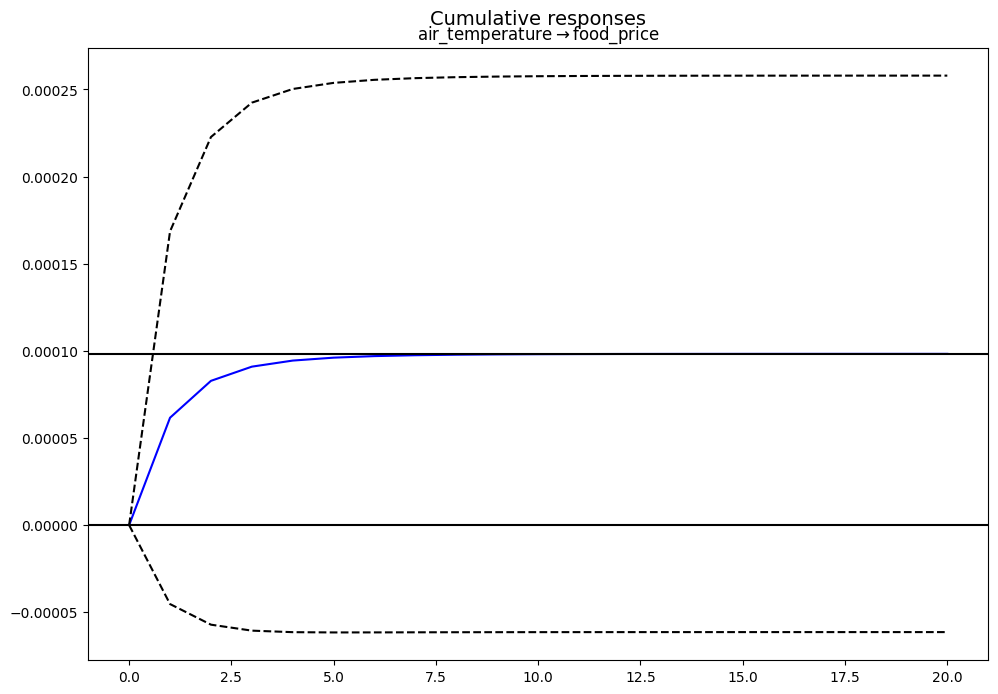

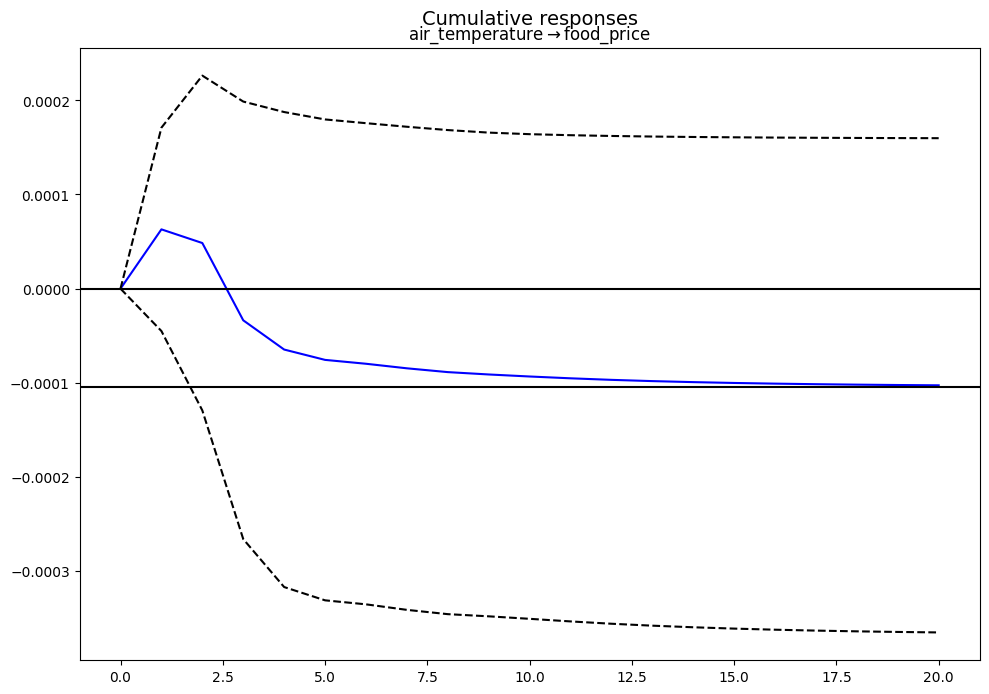

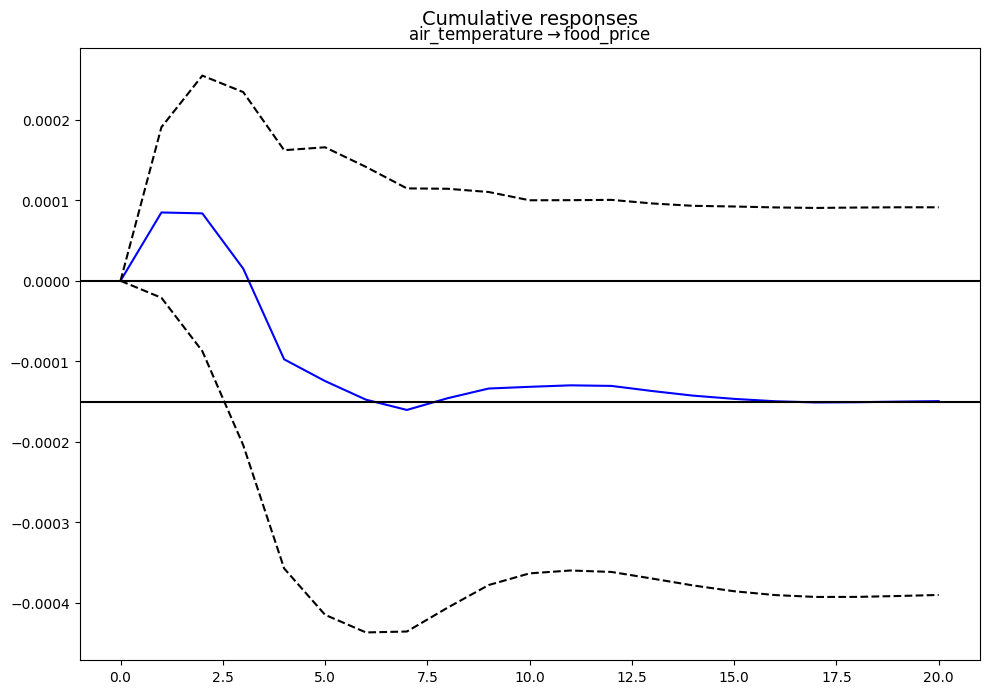

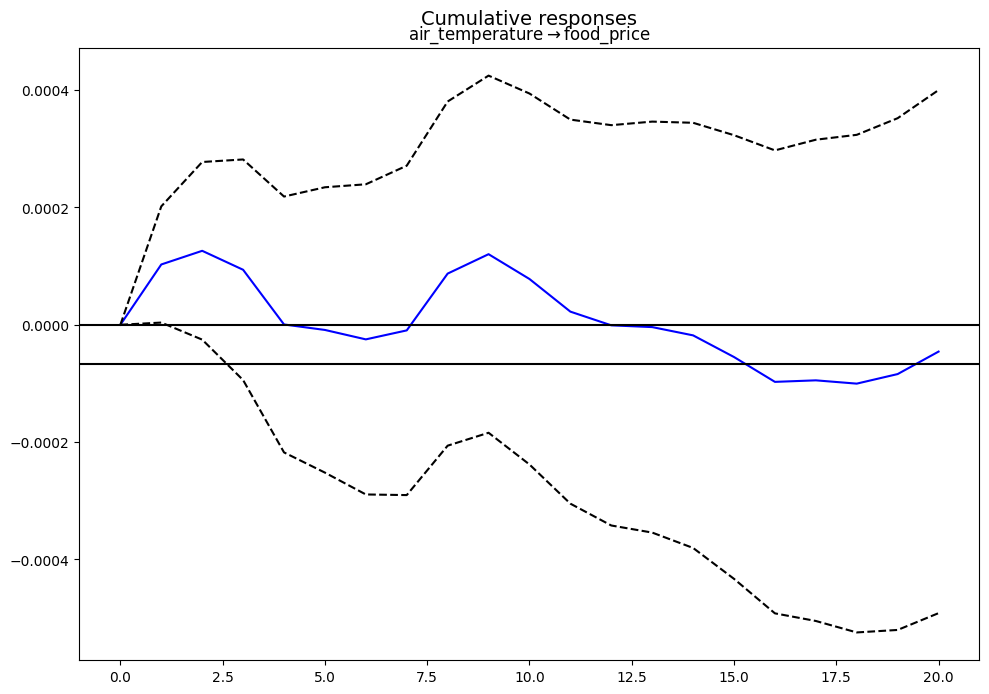

In [25]:


irf1 = VAR1.irf(20)
irf1 = irf1.plot_cum_effects(orth=False, impulse = "air_temperature", response = "food_price", figsize = (10,7))

irf3 = VAR3.irf(20)
irf3 = irf3.plot_cum_effects(orth=False, impulse = "air_temperature", response = "food_price", figsize = (10,7))

irf5 = VAR5.irf(20)
irf5 = irf5.plot_cum_effects(orth=False, impulse = "air_temperature", response = "food_price", figsize = (10,7))

irf12 = VAR12.irf(20)
irf12 = irf12.plot_cum_effects(orth=False, impulse = "air_temperature", response = "food_price", figsize = (10,7))

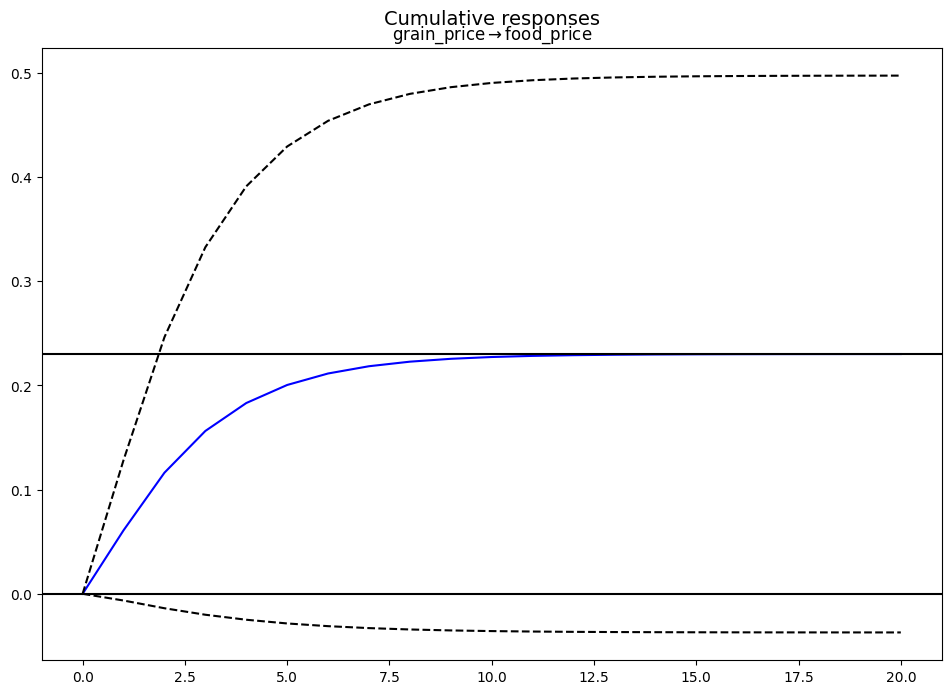

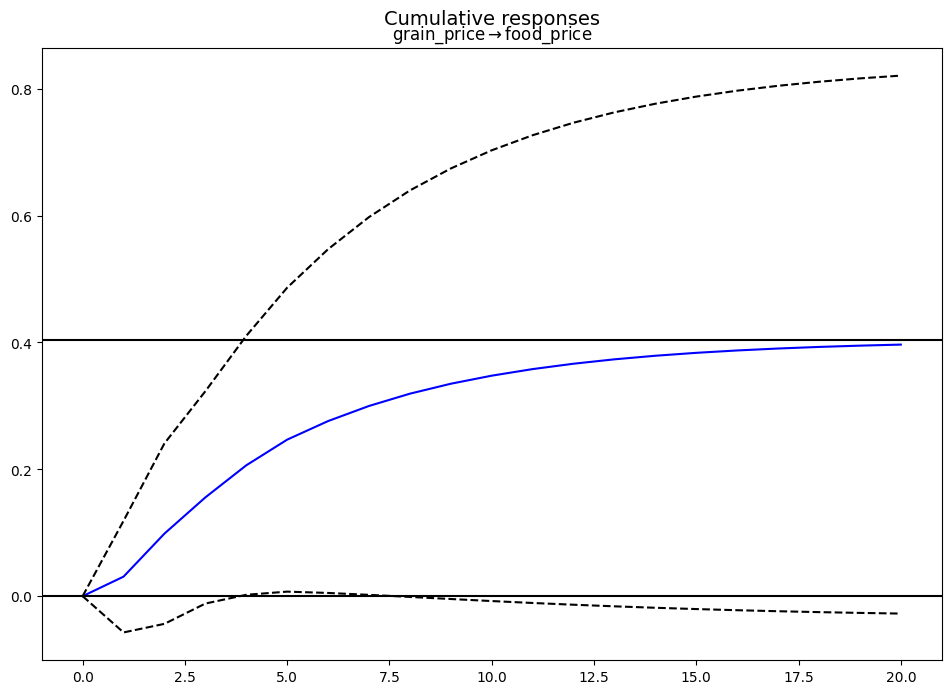

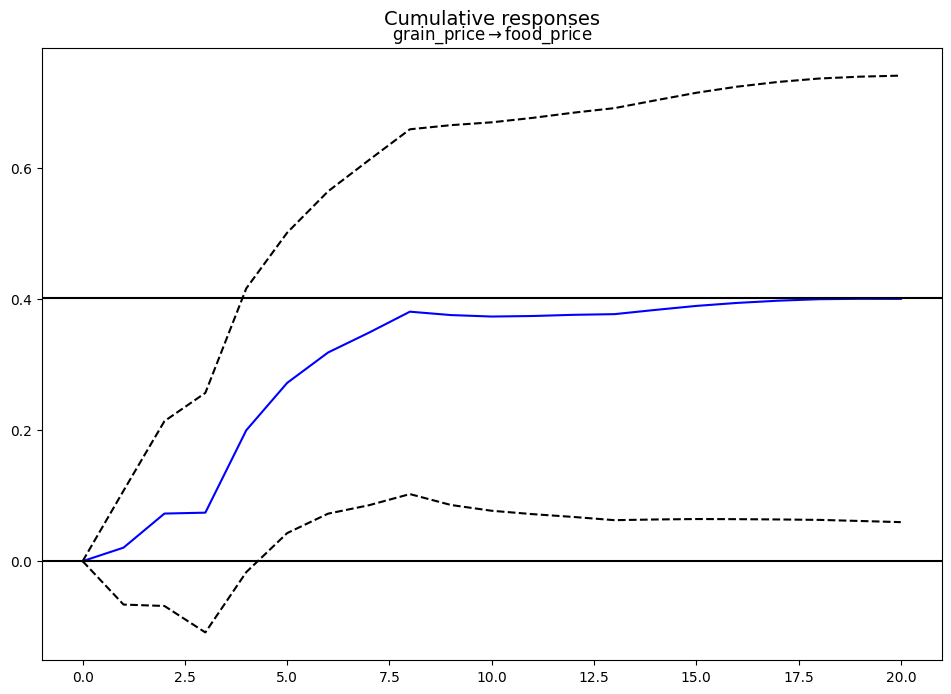

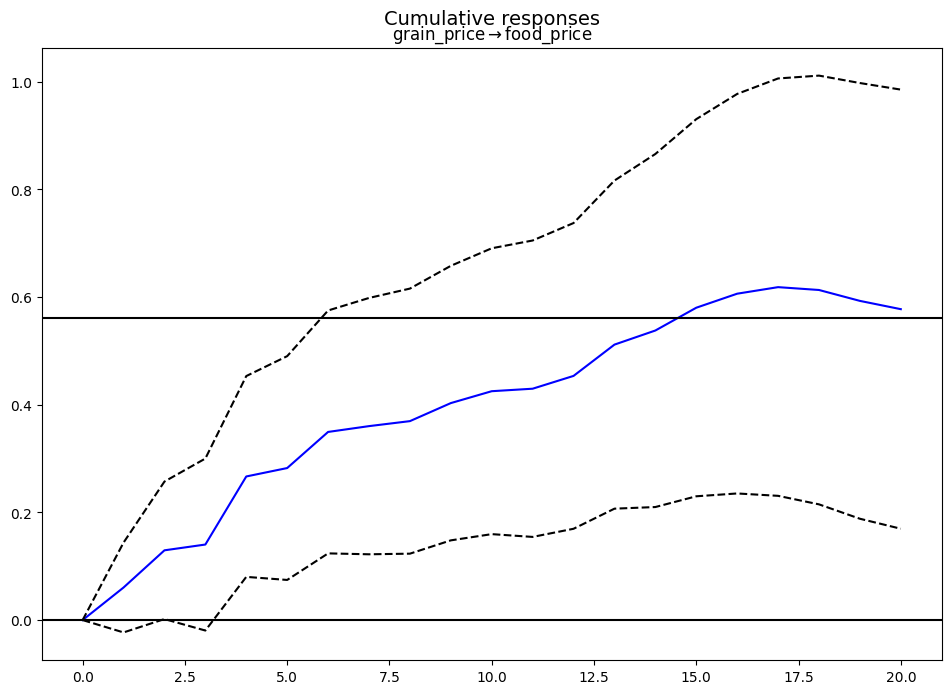

In [26]:
irf1 = VAR1.irf(20)
irf1 = irf1.plot_cum_effects(orth=False, impulse = "grain_price", response = "food_price", figsize = (10,7))

irf3 = VAR3.irf(20)
irf3 = irf3.plot_cum_effects(orth=False, impulse = "grain_price", response = "food_price", figsize = (10,7))

irf5 = VAR5.irf(20)
irf5 = irf5.plot_cum_effects(orth=False, impulse = "grain_price", response = "food_price", figsize = (10,7))

irf12 = VAR12.irf(20)
irf12 = irf12.plot_cum_effects(orth=False, impulse = "grain_price", response = "food_price", figsize = (10,7))